In [0]:
# now we create a quick function to calculate loss based on distance from centroid
def calc_loss(x,y,x_ref,y_ref):
    
    
    # calculate Euclidean distance btw person & centroid
    distance = np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 
    
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-distance)) #converts distances to probability distribution
    
    #return distance
    return loss

In [0]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    
    percentile_loss = []
    for s in select_group:
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = np.percentile(subgroup, percentile,interpolation='linear') # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss
        
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    
    return difference

In [0]:
def loss_funct(cluster0, cluster1):
  cluster0_len = len(cluster0['min_loss'])
  cluster1_len = len(cluster1['min_loss'])
  tot = cluster0_len + cluster1_len

  #individual loss summation for all points associated with centroid 0
  indiv_loss0 = cluster0['min_loss'].sum()

  #individual loss summation for all points associated with centroid 1
  indiv_loss1 = cluster1['min_loss'].sum()
  
  #sums the individual loss for all points associated with each centroid and divides byall individuals
  #total individual loss between red and blue points
  indiv_loss_tot = (indiv_loss0 + indiv_loss1) / tot

  #calculation of subgroup loss between red and blue
  subgroup_loss_div = compare_loss(cluster0, cluster1 ,0.5)

  #based on the loss function defined, we divide the divergence of the 2 groups' loss by the number of subgroups
  subgroup_div_tot = subgroup_loss_div/2

  #want to minimize this value
  return indiv_loss_tot + subgroup_div_tot




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


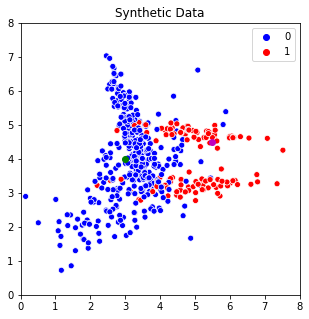

In [4]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



# Generate Imbalanced Synthetic Data
X,y = make_classification(n_samples=500, shift=4 ,n_features=2,n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.75,0.25], random_state=55)

#create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]
})

#red vs blue points
#if group = 0, then the point is in the blue group
# if group = 1, then the point is in the red group
df['group'] = y


# np.random.seed(42)

#arbitrarily picked random k (number of centroids)
k = 2

#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
centroids = {
    0: [3,4],
    1: [5.5, 4.5]
}

#colors for centroids
color_map = {0: 'g', 1: 'm'}


#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y, palette=['blue','red'])

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])

plt.xlim(0, 8)
plt.ylim(0, 8)
ax.set_title("Synthetic Data");
plt.show()



In [5]:


def assign_cluster(df, centroids):
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])

  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]

  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_0','loss_from_1']].min(axis=1)
  #color of the closest centroid to each point
  df['color'] = df['min_centr'].map(lambda x: color_map[x])
  return df


df = assign_cluster(df, centroids)
df

,x_coord,y_coord,group,loss_from_0,loss_from_1,min_centr,min_loss,color
0,3.126701,5.861518,0,0.865974,0.939124,0,0.865974,g
1,3.009882,3.865715,0,0.533611,0.928881,0,0.533611,g
2,1.910421,2.200962,0,0.891220,0.986111,0,0.891220,g
3,3.884626,4.533612,1,0.737517,0.834205,0,0.737517,g
4,3.779372,2.588979,0,0.833683,0.929004,0,0.833683,g
...,...,...,...,...,...,...,...,...
495,3.672692,4.300994,0,0.676331,0.862725,0,0.676331,g
496,4.252466,3.995263,0,0.777728,0.793437,0,0.777728,g
497,4.827376,4.849431,1,0.882379,0.680914,1,0.680914,m
498,3.590866,3.208162,0,0.728691,0.909301,0,0.728691,g


In [0]:
#all points clustered around centroid 0
clust_0 = df[df['min_centr'] == 0]
#all points clustered around centroid 1
clust_1 = df[df['min_centr'] == 1]

#all points in group 0 (blue points)
group_0 = df[df['group']==0]
#all points in group 1 (red points)
group_1 = df[df['group']==1]

#blue = 0
#red = 1

#dictionary storing total red and blue points associated with centrioid 0
clust_0_groups = {0: clust_0.loc[clust_0['group']==0, 'group'].count(), 
                  1: clust_0.loc[clust_0['group']==1, 'group'].count()}

#total number of points in cluster around centroid 0
clust0_tot = clust_0_groups[0] + clust_0_groups[1]

#dictionary storing total red and blue points associated with centrioid 1
clust_1_groups = {0: clust_1.loc[clust_1['group']==0, 'group'].count(), 
                  1: clust_1.loc[clust_1['group']==1, 'group'].count()}

#total number of points in cluster around centroid 1
clust1_tot = clust_1_groups[0] + clust_1_groups[1]


In [7]:
#Total Percentages of Red and Blue in population 
red_percent = (clust_0_groups[1] + clust_1_groups[1])/(clust0_tot + clust1_tot)
blue_percent = (clust_0_groups[0] + clust_1_groups[0])/(clust0_tot + clust1_tot)

print('red: ', red_percent)
print('blue: ', blue_percent)

red:  0.25
blue:  0.75


In [8]:
#Total Percentages Per Cluster
#Cluster 0 red percentage
clust0_percent_red = clust_0_groups[1]/clust0_tot

#Cluster 0 blue percentage
clust0_percent_blue = clust_0_groups[0]/clust0_tot

print("Cluster 0: ")
print('red: ', clust0_percent_red)
print('blue: ', clust0_percent_blue)

#Cluster 1 red percentage
clust1_percent_red = clust_1_groups[1]/clust1_tot

#Cluster 0 blue percentage
clust1_percent_blue = clust_1_groups[0]/clust1_tot

print("Cluster 1: ")
print('red: ', clust1_percent_red)
print('blue: ', clust1_percent_blue)


#new dataframe for the percentages of each group in both clusters and the total population
color_rates = pd.DataFrame({'color': ['red', 'blue'],
                            'population_level': [red_percent, blue_percent],
                            'cluster_0': [clust0_percent_red, clust0_percent_blue],
                            'cluster_1': [clust1_percent_red, clust1_percent_blue]})
color_rates

Cluster 0: 
red:  0.08376963350785341
blue:  0.9162303664921466
Cluster 1: 
red:  0.788135593220339
blue:  0.211864406779661


,color,population_level,cluster_0,cluster_1
0,red,0.25,0.08377,0.788136
1,blue,0.75,0.91623,0.211864


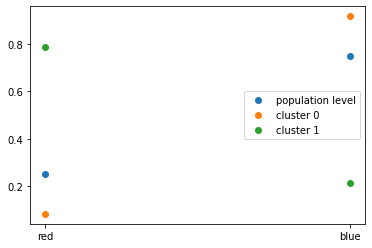

In [9]:
#plot representing the percentage differences in red/blue group representation on population/cluster level
plt.scatter(color_rates['color'], color_rates['population_level'],label='population level')
plt.scatter(color_rates['color'],color_rates['cluster_0'],label = 'cluster 0')
plt.scatter(color_rates['color'],color_rates['cluster_1'],label = 'cluster 1')
plt.legend()

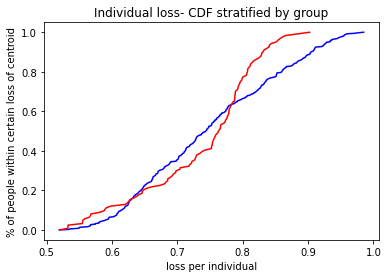

In [10]:
#CDF for all blue and red points
#cdf for group 0 (all blue points)
sorted_data_0 = group_0.sort_values(by=['min_loss'])
sorted_len_0 = len(sorted_data_0['min_loss'])
yvals_0 = np.arange(sorted_len_0)/float(sorted_len_0-1)

#cdf for group 1 (all red points)
sorted_data_1 = group_1.sort_values(by=['min_loss'])
sorted_len_1 = len(sorted_data_1['min_loss'])
yvals_1 = np.arange(sorted_len_1)/float(sorted_len_1-1)


plt.plot(sorted_data_0['min_loss'], yvals_0, 'b')
plt.plot(sorted_data_1['min_loss'], yvals_1, 'r')

plt.xlabel('loss per individual')
plt.ylabel('% of people within certain loss of centroid')
plt.title('Individual loss- CDF stratified by group')
plt.show()


#blue = 0 (blue points)
#red = 1 (red points)

In [0]:
# find subgroup loss
loss = compare_loss(group_0, group_1, .5)
#find loss that minimizes individual loss AND divergence among subgroups
tot_loss = loss_funct(clust_0, clust_1,)

In [12]:
tot_loss

0.750876907609542

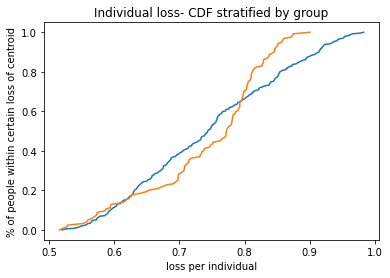

0.750876907609542
0.7475455183570263


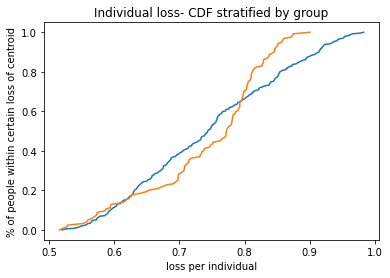

0.7475455183570263
0.7475455183570263


In [15]:
def update_centroids(centroids, x_coord, y_coord, loss):
  
  for i in centroids.keys():
    centroids[i][0] += .01
    centroids[i][1] += .01
  while True: 
    df_2 = assign_cluster(df, centroids)

    clust_0 = df_2[df_2['min_centr'] == 0]
    clust_1 = df_2[df_2['min_centr'] == 1]

    group_0 = df_2[df_2['group']==0]
    group_1 = df_2[df_2['group']==1]

    sorted_data_0 = group_0.sort_values(by=['min_loss'])
    sorted_len_0 = len(sorted_data_0['min_loss'])
    yvals_0 = np.arange(sorted_len_0)/float(sorted_len_0-1)

    sorted_data_1 = group_1.sort_values(by=['min_loss'])
    sorted_len_1 = len(sorted_data_1['min_loss'])
    yvals_1 = np.arange(sorted_len_1)/float(sorted_len_1-1)


    plt.plot(sorted_data_0['min_loss'], yvals_0)
    plt.plot(sorted_data_1['min_loss'], yvals_1)

    plt.xlabel('loss per individual')
    plt.ylabel('% of people within certain loss of centroid')
    plt.title('Individual loss- CDF stratified by group')
    plt.show()

    subgroup_loss = compare_loss(sorted_data_0, sorted_data_1, .5)
    new_loss = loss_funct(sorted_data_0, sorted_data_1)
    print(loss)
    print(new_loss)
    if new_loss < loss:
      loss = new_loss
    else:
      return
        



  

update_centroids(centroids, df['x_coord'], df['y_coord'], tot_loss)